In [1]:
import numpy as np
import pandas as pd
from midaspy import model
from midaspy.custom_model import MIDASRegressor
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
# define BetaWeights class
# from https://github.com/Yoseph-Zuskin/midaspy/blob/master/midaspy/iolib.py
class BetaWeights:
    def __init__(self, theta1, theta2, theta3=None):
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3

    def weights(self, nlags):
        """ 
        Evenly-spaced Beta polynomial weighting method.
        
        Parameters
        ----------
        nlags : int
            Number of lag terms in projection matrix.
        
        Returns
        -------
        array : numpy.array
            Polynomial weights.
        """
        eps = np.spacing(1)
        u = np.linspace(eps, 1.0 - eps, nlags)

        theta1 = np.clip(self.theta1, 0.1, 10)
        theta2 = np.clip(self.theta2, 0.1, 10)

        beta_vals = u ** (theta1 - 1) * (1 - u) ** (theta2 - 1)

        beta_vals = beta_vals / sum(beta_vals)

        if self.theta3 is not None:
            w = beta_vals + self.theta3
            return w / sum(w)

        return beta_vals

    def x_weighted(self, x, params):
        self.theta1, self.theta2 = params
        w = self.weights(x.shape[1])
        return np.dot(x, w), np.tile(w.T, (x.shape[0], 1))

    @property
    def num_params(self):
        return 2 if self.theta3 is None else 3

    @staticmethod
    def init_params():
        return np.array([1., 5.])

# patch frequency detection logic to accept YE-DEC 
def _patched_frequency_detection(freq, horizon):
    if freq in ('A', 'A-DEC', 'YE-DEC'):
        return relativedelta(years=horizon)
    elif freq in ('Q', 'Q-DEC'):
        return relativedelta(months=3 * horizon)
    elif freq in ('M', 'MS'):
        return relativedelta(months=horizon)
    elif freq in ('W',):
        return relativedelta(weeks=horizon)
    else:
        raise SystemError('unknown frequency detection error, please log and report this to module author via GitHub')

# patch into midaspy
model._infer_time_delta_from_freq = _patched_frequency_detection

In [4]:
spei_df.head()

,date,Muchinga,Eastern,Northern,Lusaka,Southern,Western,North-Western,Luapula,Copperbelt,Central
0,2000-01-31,-0.335935,0.071792,0.359571,1.018822,0.129393,-0.983762,-0.404359,0.194453,-0.200033,0.226558
1,2000-02-29,-0.655010,-0.019932,-0.100002,1.111797,0.333732,-0.809749,-0.639070,0.008713,-0.117974,0.346596
2,2000-03-31,-0.603271,0.111299,-0.241531,1.298886,0.544811,-0.345663,-0.434044,0.021194,0.288008,0.701847
3,2000-04-30,-0.710754,0.144254,-0.370088,1.326682,0.594507,-0.279840,-0.414683,-0.130628,0.280625,0.728312
4,2000-05-31,-0.786667,0.094418,-0.481320,1.283639,0.603209,-0.256084,-0.456284,-0.236774,0.199494,0.681178


In [5]:
lcluc_df.head()

,province,year,loss_ha
0,Central,2001,3383.418152
1,Copperbelt,2001,6672.296663
2,Eastern,2001,1616.663006
3,Luapula,2001,1829.614516
4,Lusaka,2001,1275.028298


## Province Level

In [7]:
# load csv files
spei_df = pd.read_csv('province_spei_average.csv', parse_dates=['date'])
lcluc_df = pd.read_csv('province_lcluc.csv')

# set verbose mode
verbose = False

# convert spei data to long format
spei_long = spei_df.melt(id_vars='date', var_name='province', value_name='spei')
spei_long['spei'] = spei_long['spei'].interpolate()

# set lag length (12 months)
lags = 12

# empty dict to store results
results = {}

# loop through provinces 
provinces = spei_long['province'].unique()
# deal with Muchinga disparity problem
valid_provinces = set(lcluc_df['province'].unique())
provinces = [p for p in spei_long['province'].unique() if p in valid_provinces]

for province_name in provinces:
    spei_province = spei_long[spei_long['province'] == province_name].sort_values('date')
    lcluc_province = lcluc_df[lcluc_df['province'] == province_name].sort_values('year')
    X_lagged = []
    Y = []
    valid_years = []

    for year in lcluc_province['year']:
        end_date = pd.Timestamp(f'{year}-12-31')
        start_date = end_date - pd.DateOffset(months = lags -1)
        spei_window = spei_province[(spei_province['date'] >= start_date) &
                           (spei_province['date'] <= end_date)]

        if len(spei_window) == lags:
            X_lagged.append(spei_window['spei'].values)
            Y.append(lcluc_province[lcluc_province['year'] == year]['loss_ha'].values[0])
            valid_years.append(year)
        else:
            if verbose:
                print(f"[DEBUG] {province_name} - {year}: only {len(spei_window)} months found (need 12)")

    if verbose:
        print(f"[DEBUG] {province_name}: {len(X_lagged)} years matched with full 12-month SPEI data")
            

    if len(X_lagged) > 0:
        horizon = 1

        X = pd.DataFrame(X_lagged, columns=[f"spei_lag_{i+1}" for i in range(lags)])
        X.index = pd.date_range(start=f'{valid_years[0]}-12-31', periods=len(X), freq='YE-DEC')

        # align Y
        Y = pd.Series(Y, name='loss_ha')
        Y.index = X.index

        # extract aligned X for model fitting
        X_for_model = X.loc[Y.index]
        
        if X_for_model.isna().any().any():
            print(f'[SKIP] {province_name}: NAs found in X used for model')
            continue

        if verbose:
            print(f"[DEBUG] Final aligned X.shape: {X.shape}, Y.shape: {Y.shape}")

        # fit midas model
        try:
            model = MIDASRegressor(
                endog=Y,
                exog=X_for_model,
                xlag=0,
                poly='beta',
                horizon=horizon,
                custom=True
            )
            model.fit()
        except ValueError as e:
            print(f'[SKIP] {province_name}: {e}')
            continue
        params = np.array(model.params).flatten()
        if len(params) < 5:
            print(f"Model fit failed or incomplete for {province_name}: {params}")
            continue
        beta = BetaWeights(*params[2:5])
        weights = beta.weights(lags)

        X_with_const = pd.concat([
            pd.DataFrame({'Constant': 1}, index=X_for_model.index),
            X_for_model
        ], axis = 1)

        results[province_name] = {
            'model': model,
            'weights': weights,
            'intercept': params[0],
            'predictions': model.predict(X_with_const),
            'observed': Y
        }

        print(f'Model fitted for {province_name}')
    else:
        print(f'Not enough data for {province_name}')

[DEBUG] Exogenous freq for spei_lag_1: Y
[DEBUG] Exogenous freq for spei_lag_2: Y
[DEBUG] Exogenous freq for spei_lag_3: Y
[DEBUG] Exogenous freq for spei_lag_4: Y
[DEBUG] Exogenous freq for spei_lag_5: Y
[DEBUG] Exogenous freq for spei_lag_6: Y
[DEBUG] Exogenous freq for spei_lag_7: Y
[DEBUG] Exogenous freq for spei_lag_8: Y
[DEBUG] Exogenous freq for spei_lag_9: Y
[DEBUG] Exogenous freq for spei_lag_10: Y
[DEBUG] Exogenous freq for spei_lag_11: Y
[DEBUG] Exogenous freq for spei_lag_12: Y
Model fitted for Eastern
[DEBUG] Exogenous freq for spei_lag_1: Y
[DEBUG] Exogenous freq for spei_lag_2: Y
[DEBUG] Exogenous freq for spei_lag_3: Y
[DEBUG] Exogenous freq for spei_lag_4: Y
[DEBUG] Exogenous freq for spei_lag_5: Y
[DEBUG] Exogenous freq for spei_lag_6: Y
[DEBUG] Exogenous freq for spei_lag_7: Y
[DEBUG] Exogenous freq for spei_lag_8: Y
[DEBUG] Exogenous freq for spei_lag_9: Y
[DEBUG] Exogenous freq for spei_lag_10: Y
[DEBUG] Exogenous freq for spei_lag_11: Y
[DEBUG] Exogenous freq for 

## Plot

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# combine results into tidy dataframe
plot_data = []

for province, res in results.items():
    df = pd.DataFrame({
        'date': res['observed'].index,
        'observed': res['observed'].values,
        'predicted': res['predictions'].values.flatten()
    })
    df['province'] = province
    df['residual'] = df['observed'] - df['predicted']
    plot_data.append(df)

plot_df = pd.concat(plot_data)

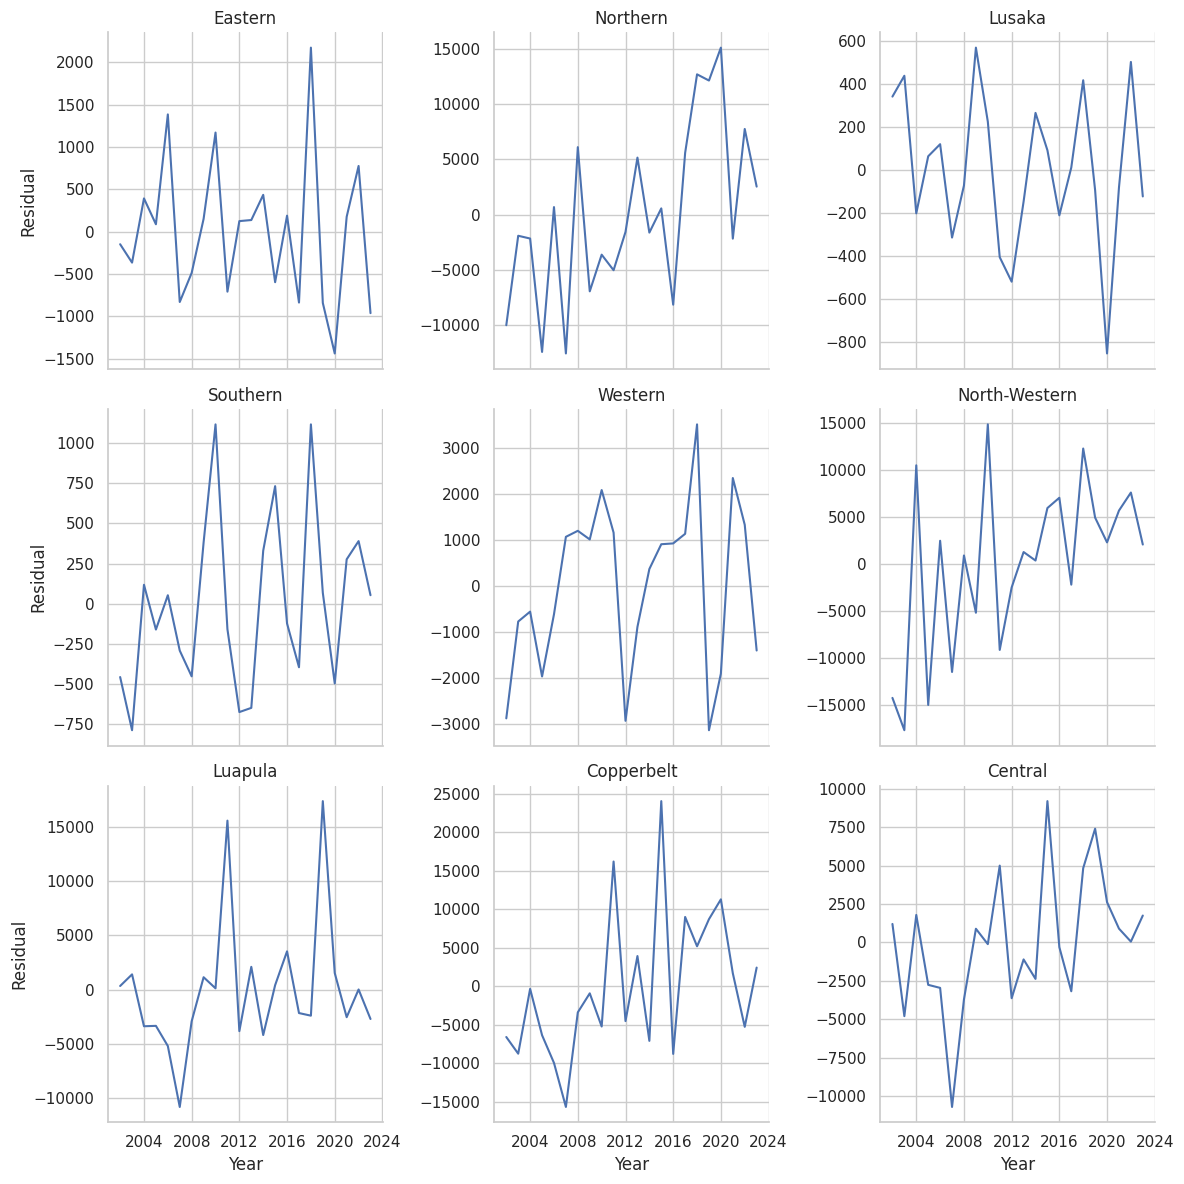

In [6]:
sns.set(style='whitegrid')

g = sns.FacetGrid(plot_df, col='province', col_wrap=3, height=4, sharey=False)
g.map_dataframe(sns.lineplot, x='date', y='residual')
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Year', 'Residual')
plt.tight_layout()
plt.show()

## Code graveyard

In [ ]:
    if len(X_lagged) > 0:
        X = pd.DataFrame(X_lagged, index=pd.to_datetime(valid_years, format="%Y"))
        Y = pd.Series(Y, index=pd.to_datetime(valid_years, format="%Y"))
        Y.index = pd.date_range(start=f'{valid_years[0]}-12-31', periods=len(valid_years), freq='YE-DEC')
        X.index = Y.index

In [ ]:

        
        horizon = 1

        required_len = len(Y) + lags + horizon - 1
        padding_len = required_len - len(X_lagged)
        if padding_len > 0:
            padding = np.full((padding_len, lags), np.nan)
            X_lagged_extended = np.vstack([X_lagged, padding])
        else:
            X_lagged_extended = np.array(X_lagged)

In [ ]:
        
        Y.index = pd.date_range(
            start=X.index[lags + horizon -1],
            periods=len(Y),
            freq='YE-DEC'
        )

In [ ]:
        # trim X to align with Y with extra rows for the projection matrix
        X = X.loc[X.index >= Y.index[0]]

        # ensure X is long enough for projection matrix
        critical_rows = len(Y) + lags + horizon - 1
        if len(X) < critical_rows:
            print(f'[SKIP] {province_name}: not enough rows in X after trimming (need {critical_rows}, have {len(X)})')
            continue

In [ ]:
 if len(X) < required_len:
            padding_len = required_len - len(X)
            print(f"[DEBUG] Padding {padding_len} rows to X")

            padding_index = pd.date_range(start=X.index[-1] + pd.offsets.YearEnd(1), periods=padding_len, freq='YE-DEC') 

            padding = pd.DataFrame(
                np.full((padding_len, lags), np.nan),
                columns=X.columns,
                index=padding_index
            )
            X = pd.concat([X, padding])